In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk

sns.set_style("whitegrid")

In [2]:
df = pd.read_csv('english.csv')
df.columns

Index(['Unnamed: 0', 'author', 'content'], dtype='object')

In [3]:
df = df[['author', 'content']]
df.columns

Index(['author', 'content'], dtype='object')

In [4]:
l1 = len(df)
df.dropna(inplace=True)
print(f'droped {l1-len(df)} of {l1} rows')

droped 0 of 1658 rows


/home/mel/.local/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


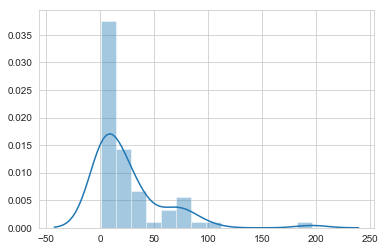

In [5]:
authors = df['author'].unique()
authors_dist = np.array(list((df['author'] == a).sum() for a in authors))
authors_dist.sort()
sns.distplot(authors_dist)

In [6]:
dist = [(a, (df['author'] == a).sum()) for a in authors]
dist.sort(key=lambda x: -x[1])
most_frequent = [n for n, _ in dist[:5]]
mask = df['author'].apply(lambda x: x in most_frequent)
most_freq_df = df[mask]
print(most_freq_df.head())

           author                                            content
18     John Donne  Batter my heart, three-person'd God, for you  ...
25  D.H. Lawrence  As a drenched, drowned bee  Hangs numb and hea...
40     John Donne  DEAR love, for nothing less than thee  Would I...
77    Oscar Wilde  Two crowned Kings, and One that stood alone  W...
89  D.H. Lawrence  When the bare feet of the baby beat across the...


In [7]:
thre = 50
dist = [(a, (df['author'] == a).sum()) for a in authors]
droplist = [a for a, i in dist if i < thre]
mask = df['author'].apply(lambda x: x not in droplist)
thre_df1 = df[mask]
take_list = [a for a, i in dist if i > thre]
author_series, content_series = [], []
for a in take_list:
    author_series += [a] * thre
    content_series += df[df['author'] == a]['content'].iloc[:thre].tolist()
thre_df2 = pd.DataFrame(data={'author': author_series, 'content': content_series})
balanced_df = pd.concat([thre_df1, thre_df2])
print(f'{len(np.unique(balanced_df["author"]))} unique poets of {len(np.unique(df["author"]))}')

12 unique poets of 65


In [8]:
content = balanced_df['content']
author = balanced_df['author']

In [9]:
print(author.iloc[0])

John Keats


In [10]:
print(content.iloc[0])

Season of mists and mellow fruitfulness!  Close bosom-friend of the maturing sun;  Conspiring with him how to load and bless  With fruit the vines that round the thatch-eaves run;  To bend with apples the mossed cottage-trees,  And fill all fruit with ripeness to the core;  To swell the gourd, and plump the hazel shells  With a sweet kernel; to set budding more,  And still more, later flowers for the bees,  Until they think warm days will never cease,  For Summer has o'erbrimmed their clammy cells.  Who hath not seen thee oft amid thy store?  Sometimes whoever seeks abroad may find  Thee sitting careless on a granary floor,  Thy hair soft-lifted by the winnowing wind;  Or on a half-reaped furrow sound asleep,  Drowsed with the fume of poppies, while thy hook  Spares the next swath and all its twined flowers;  And sometimes like a gleaner thou dost keep  Steady thy laden head across a brook;  Or by a cider-press, with patient look,  Thou watchest the last oozings, hours by hours.  Where

In [11]:
import re

def clean(string):
    for char in ['\r', '\n', '-', ',', '.', ';', '(', ')', '!', '?']:
        string = string.replace(char, ' ')
    return re.sub('\s+', ' ', string)

In [12]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
content = content.apply(lambda x: stemmer.stem(clean(x)))

In [13]:
print(content.iloc[0])

season of mists and mellow fruitfulness close bosom friend of the maturing sun conspiring with him how to load and bless with fruit the vines that round the thatch eaves run to bend with apples the mossed cottage trees and fill all fruit with ripeness to the core to swell the gourd and plump the hazel shells with a sweet kernel to set budding more and still more later flowers for the bees until they think warm days will never cease for summer has o'erbrimmed their clammy cells who hath not seen thee oft amid thy store sometimes whoever seeks abroad may find thee sitting careless on a granary floor thy hair soft lifted by the winnowing wind or on a half reaped furrow sound asleep drowsed with the fume of poppies while thy hook spares the next swath and all its twined flowers and sometimes like a gleaner thou dost keep steady thy laden head across a brook or by a cider press with patient look thou watchest the last oozings hours by hours where are the songs of spring ay where are they th

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(content)

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(author)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [18]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, criterion='entropy')
rfc.fit(X_train, y_train)
if X_test.shape[0]:
   print(f'accuracy: {accuracy_score(rfc.predict(X_test), y_test)}')

accuracy: 0.8115631691648822


In [19]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50, 50))
mlp.fit(X_train, y_train)
if X_test.shape[0]:
   print(f'accuracy: {accuracy_score(mlp.predict(X_test), y_test)}')

accuracy: 0.9207708779443254


In [20]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', C=2.0, gamma=1.0)
svc.fit(X_train, y_train)
if X_test.shape[0]:
   print(f'accuracy: {accuracy_score(svc.predict(X_test), y_test)}')

accuracy: 0.8372591006423983


In [21]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier([
   ('rfc', rfc),
   ('mlp', mlp),
   ('svc', svc)
])

vc.fit(X_train, y_train)
if X_test.shape[0]:
   print(f'accuracy: {accuracy_score(vc.predict(X_test), y_test)}')

accuracy: 0.8758029978586723
